##### Arthur de Sá - 212006577
##### Arthur Mota - 200014935
##### Thiago Carrijo - 211068350
##### Victor André - 211026664

### Interpretando Aparências de Tumores

Compreender as características visuais dos diferentes tipos de tumores cerebrais é essencial para interpretar as previsões de modelos. Embora este conjunto de dados forneça anotações com caixas delimitadoras, aqui está um guia geral para ajudar a identificar os tumores com base em suas aparências típicas em exames médicos (especificamente, presumindo que essas imagens sejam provavelmente de ressonância magnética - MRI - ou tomografia computadorizada - CT -, embora isso precise ser verificado se a fonte dos dados for conhecida). Lembre-se de que a aparência pode variar significativamente, e este é um resumo simplificado.

#### **Glioma**
Os gliomas são tumores que se originam das células gliais, que dão suporte aos neurônios no cérebro.

- **Aparência:** 
  - Costumam ter uma forma irregular e bordas mal definidas, o que os faz parecer infiltrativos.
  - A textura interna pode ser heterogênea, com áreas de necrose (tecido morto), hemorragia (sangramento) ou cistos (cavidades preenchidas por líquido).
  - A intensidade do tumor nas imagens de MRI (ou CT) varia dependendo do tipo específico de glioma e da presença dessas características internas.
  - Gliomas de grau mais alto (como o glioblastoma) são mais propensos a ter essas características irregulares.

#### **Meningioma**
Os meningiomas surgem das meninges, as membranas que envolvem o cérebro e a medula espinhal.

- **Aparência:** 
  - Geralmente são massas bem definidas, de formato arredondado ou oval, aderidas à dura-máter (camada mais externa das meninges).
  - Frequentemente, apresentam uma base larga contra o crânio.
  - Em imagens com contraste, os meningiomas geralmente mostram um realce forte e homogêneo (tornam-se mais brilhantes após a injeção do agente de contraste).
  - Um achado característico é a "cauda dural" (espessamento da dura-máter que se estende a partir do tumor).

#### **Adenoma de Hipófise**
Os adenomas hipofisários são tumores que se desenvolvem na glândula pituitária, uma pequena glândula localizada na base do cérebro.

- **Aparência:** 
  - Esses tumores estão localizados na sela túrcica (uma estrutura óssea que abriga a hipófise).
  - Microadenomas (tumores pequenos) podem ser sutis e requerer sequências específicas de MRI para detecção.
  - Macroadenomas (tumores maiores) podem comprimir o quiasma óptico (onde os nervos ópticos se cruzam), levando a distúrbios visuais.
  - Normalmente, têm formato arredondado ou oval e podem realçar com contraste, mas o padrão pode variar.


In [ ]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from dataclasses import dataclass, field
from torch.utils.data import Dataset
from torchvision import transforms
from ultralytics import YOLO
from torchvision.transforms import ColorJitter
import torchvision.transforms.functional as F
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
from dataclasses import dataclass, field
from pathlib import Path

@dataclass
class Config:
    """
    Project configuration.

    Attributes:
        data_root (Path): Directory for datasets.
        class_labels (dict): Mapping of class indices to labels.
        class_colors (dict): Mapping of class indices to colors.
        target_image_size (int): Target size to which images are resized.
        batch_size (int): Number of samples per training batch.
        validation_split (float): Fraction of data reserved for validation.
        seed (int): Random seed for reproducibility.
        initial_lr (float): Initial learning rate.
        num_epochs (int): Total number of training epochs.
        early_stop_patience (int): Number of epochs to wait for improvement before stopping.
        dropout (float): Dropout rate.
        confidence_threshold (float): Minimum confidence to consider a detection valid.
        iou_threshold (float): IOU threshold for valid detection.
        weight_decay (float): Weight decay factor for regularization.
    """
    data_root: Path = Path("./datasets")
    class_labels: dict = field(
        default_factory=lambda: {
            0: 'Glioma',
            1: 'Meningioma',
            3: 'Pituitary',
            2: 'Background',
        }
    )
    class_colors: dict = field(
        default_factory=lambda: {
            0: 'darkmagenta',
            1: 'orange',
            3: 'darkcyan',
            2: 'darkslategray',
        }
    )
    target_image_size: int = 640
    batch_size: int = 12
    validation_split: float = 0.2
    seed: int = 42
    initial_lr: float = 1e-3
    num_epochs: int = 5
    early_stop_patience: int = 15
    dropout: float = 0.2
    confidence_threshold: float = 0.4
    iou_threshold: float = 0.45
    weight_decay: float = 0.0005

config = Config()


In [ ]:
def plot_class_distribution():
    """
    Plot class distributions for train and validation sets.

    Reads label files from the 'labels' directory of each split (train/val),
    counts occurrences per class using global config mappings, and displays
    bar charts of the distributions.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, split in enumerate(['train', 'val']):
        class_counts = {cls: 0 for cls in config.class_labels.values()}
        label_dir = config.data_root / split / 'labels'
        
        for label_file in label_dir.glob('*.txt'):
            with open(label_file, 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    class_name = config.class_labels.get(class_id, 'Unknown')
                    class_counts[class_name] += 1
                    
        classes = list(config.class_labels.values())
        counts = [class_counts[cls] for cls in classes]
        colors = [config.class_colors[k] for k in config.class_labels.keys()]
        
        ax[idx].bar(classes, counts, color=colors)
        ax[idx].set_title(f'Class Distribution - {split.capitalize()}')
        ax[idx].set_xlabel('Class')
        ax[idx].set_ylabel('Count')
        ax[idx].tick_params(axis='x', rotation=45)
        ax[idx].grid(True, alpha=0.3)
        
        for i, count in enumerate(counts):
            ax[idx].text(i, count, str(count), ha='center', va='bottom')
            
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_dataset_samples(dataset, num_samples=6):
    """
    Display random dataset samples with bounding boxes and labels.

    Parameters:
        dataset: An iterable where each sample is a dict containing:
                 - 'image': A tensor representing the image.
                 - 'boxes': A tensor with bounding box coordinates.
                 - 'labels': A tensor with class labels.
        num_samples (int, optional): Number of random samples to display (default is 6).

    The function selects random samples, converts images to uint8 if needed,
    and overlays bounding boxes with class labels on a 2x3 grid.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, ax in zip(indices, axes):
        sample = dataset[idx]
        image = sample['image'].permute(1, 2, 0).numpy()
        boxes = sample['boxes'].numpy()
        labels = sample['labels'].numpy()

        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Sample {idx}')

        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            class_name = config.class_labels.get(int(label), 'Unknown')
            color = config.class_colors.get(int(label), 'red')

            rect = plt.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            ax.text(x_min, y_min - 5, class_name,
                    color=color, fontsize=10, weight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.tight_layout()
    plt.show()


In [ ]:
class BrainTumorDataset(Dataset):
    """
    Dataset for brain tumor images with bounding boxes and labels.

    Args:
        split (str): Dataset split (e.g., 'train', 'val').
        transform (callable, optional): Function to transform images.
        augment (bool, optional): Whether to apply augmentations.

    Attributes:
        images (list): Sorted list of image file paths.
        labels (list): Sorted list of label file paths.
    """
    def __init__(self, split: str, transform=None, augment: bool = False):
        self.root = config.data_root / split
        self.image_dir = self.root / 'images'
        self.label_dir = self.root / 'labels'
        self.transform = transform
        self.augment = augment

        image_files = {f.stem for f in self.image_dir.glob('*.jpg')}
        label_files = {f.stem for f in self.label_dir.glob('*.txt')}
        valid_files = image_files & label_files

        self.images = sorted(self.image_dir / f'{stem}.jpg' for stem in valid_files)
        self.labels = sorted(self.label_dir / f'{stem}.txt' for stem in valid_files)

    def __len__(self):
        """Return the number of samples."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve a sample by index.

        Returns:
            dict: Contains 'image' (transformed image tensor), 'boxes' (bounding boxes tensor),
                  and 'labels' (class labels tensor).
        """
        image = Image.open(self.images[idx]).convert("RGB")
        orig_width, orig_height = image.size
        label_path = self.labels[idx]

        boxes, labels = self.parse_label(label_path, (orig_width, orig_height))

        if self.augment:
            image, boxes = self.apply_augmentations(image, boxes)

        if self.transform:
            image = self.transform(image)
            new_height, new_width = image.shape[1], image.shape[2]
            boxes = self.scale_boxes(boxes, orig_width, orig_height, new_width, new_height)

        return {'image': image, 'boxes': boxes, 'labels': labels}

    def scale_boxes(self, boxes, orig_w, orig_h, new_w, new_h):
        """
        Scale bounding boxes to the dimensions of the transformed image.

        Args:
            boxes (Tensor): Original bounding boxes.
            orig_w (int): Original image width.
            orig_h (int): Original image height.
            new_w (int): New image width.
            new_h (int): New image height.

        Returns:
            Tensor: Scaled bounding boxes.
        """
        x_scale = new_w / orig_w
        y_scale = new_h / orig_h

        boxes[:, 0] *= x_scale
        boxes[:, 1] *= y_scale
        boxes[:, 2] *= x_scale
        boxes[:, 3] *= y_scale

        return boxes

    def parse_label(self, label_path: Path, img_size: tuple):
        """
        Parse a label file to extract bounding boxes and class IDs.

        Args:
            label_path (Path): Path to the label file.
            img_size (tuple): Original image dimensions (width, height).

        Returns:
            tuple: (Tensor of bounding boxes, Tensor of class IDs)
        """
        boxes = []
        class_ids = []
        img_w, img_h = img_size

        with open(label_path, 'r') as f:
            for line in f:
                cls_id, x_cent, y_cent, w, h = map(float, line.strip().split())
                x_min = (x_cent - w/2) * img_w
                y_min = (y_cent - h/2) * img_h
                x_max = (x_cent + w/2) * img_w
                y_max = (y_cent + h/2) * img_h

                boxes.append([x_min, y_min, x_max, y_max])
                class_ids.append(int(cls_id))

        return (
            torch.tensor(boxes, dtype=torch.float32),
            torch.tensor(class_ids, dtype=torch.long)
        )

    def apply_augmentations(self, image, boxes):
        """
        Apply random augmentations to the image and adjust bounding boxes accordingly.

        Args:
            image (PIL.Image): Original image.
            boxes (Tensor): Bounding boxes.

        Returns:
            tuple: (Augmented image, adjusted bounding boxes)
        """
        if np.random.rand() > 0.5:
            image = F.hflip(image)
            boxes[:, [0, 2]] = image.width - boxes[:, [2, 0]]

        if np.random.rand() > 0.5:
            jitter = ColorJitter(0.3, 0.2, 0.2, 0.1)
            image = jitter(image)

        return image, boxes


#### Modelo Utilizado: YOLOv8m

O **YOLOv8m** foi empregado para detectar tumores cerebrais em ressonâncias magnéticas, adaptado via transferência de aprendizado para 4 classes (Glioma, Meningioma, Pituitary, Background).

#### Arquitetura

- **Camadas Totais:** 295  
- **Parâmetros:** ~25,86 milhões  
- **GFLOPs:** 79.1

#### Blocos Principais

- **Backbone:**  
  - Convoluções iniciais para extração de features.  
  - Blocos *C2f* para refino e fusão de informações.  
  - Módulo *SPPF* para pooling em múltiplas escalas.

- **Upsampling e Concatenação:**  
  - Camadas de upsampling e concatenação combinam informações de diferentes escalas.

- **Cabeça de Detecção:**  
  - Módulo *Detect* que utiliza 3 escalas (canais 192, 384, 576) para gerar as predições (caixas delimitadoras e scores).

## Configuração de Treinamento

- **Resolução:** 640×640  
- **Épocas:** 5  
- **Batch Size:** 12  
- **Taxa de Aprendizado:** 0.001  
- **Otimizador:** AdamW (weight decay = 0.0005)  
- **Dropout:** 0.2  
- **Data Augmentation:** mosaic, mixup, copy-paste, rotações (até 15°), translação, escala, cisalhamento e erasing.  
- **AMP:** Utilizado para Mixed Precision.


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
"""
Global device configuration:
Selects 'cuda' if available, otherwise defaults to CPU.
"""

def initialize_model(device: torch.device) -> YOLO:
    """
    Initialize a YOLO model and move it to the specified device.

    Args:
        device (torch.device): Target device for model computation.

    Returns:
        YOLO: The initialized YOLO model on the specified device.
    """
    model = YOLO("yolov8m.pt")
    model.to(device)
    return model

def train_model(model: YOLO, data_yaml: Path) -> tuple:
    """
    Train the YOLO model using dataset configuration from a YAML file.

    Args:
        model (YOLO): The YOLO model instance to train.
        data_yaml (Path): Path to the YAML file with dataset configuration.

    Returns:
        tuple: (results, model) where 'results' contains training logs and metrics,
               and 'model' is the trained YOLO model.
    """
    results = model.train(
        data=data_yaml,
        epochs=config.num_epochs,
        imgsz=config.target_image_size,
        batch=config.batch_size,
        lr0=config.initial_lr,
        patience=config.early_stop_patience,
        dropout=config.dropout,
        optimizer='AdamW',
        weight_decay=config.weight_decay,
        mixup=0.1,
        copy_paste=0.1,
        degrees=15,
        translate=0.2,
        scale=0.5,
        shear=0.2,
        erasing=0.3,
        mosaic=0.8,
        cos_lr=True,
        label_smoothing=0.1,
        overlap_mask=True,
        device=device,
        verbose=True
    )
    return results, model


In [ ]:
def compare_predictions(model, dataset, num_samples=3, confidence_threshold=0.5):
    """
    Display side-by-side comparisons of model predictions and ground truth.

    Args:
        model: The object detection model.
        dataset: A dataset where each sample is a dict with keys 'image', 'boxes', and 'labels'.
        num_samples (int, optional): Number of random samples to visualize (default: 3).
        confidence_threshold (float, optional): Minimum confidence to display predictions (default: 0.5).

    The function randomly selects samples, obtains predictions, filters them by confidence,
    and plots the prediction results next to the ground truth.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))
    
    if num_samples == 1:
        axes = axes[np.newaxis, :]

    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image_tensor = sample['image'].unsqueeze(0).to(device)
        orig_image = (image_tensor.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

        with torch.no_grad():
            results = model.predict(image_tensor)

        pred_boxes = results[0].boxes.xyxy.cpu().numpy()
        pred_scores = results[0].boxes.conf.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy().astype(int)
        mask = pred_scores >= confidence_threshold
        pred_boxes = pred_boxes[mask]
        pred_scores = pred_scores[mask]
        pred_classes = pred_classes[mask]

        gt_boxes = sample['boxes'].cpu().numpy()
        gt_labels = sample['labels'].cpu().numpy().astype(int)

        ax1, ax2 = axes[i]

        ax1.imshow(orig_image)
        for box, score, cls in zip(pred_boxes, pred_scores, pred_classes):
            x1, y1, x2, y2 = box
            color = config.class_colors.get(int(cls), 'red')
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            ax1.add_patch(rect)
            ax1.text(x1, y1 - 5, f"{config.class_labels[int(cls)]} {score:.2f}",
                     color=color, fontsize=10, weight='bold',
                     bbox=dict(facecolor='white', alpha=0.7))

        ax2.imshow(orig_image)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            color = config.class_colors.get(int(label), 'green')
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            ax2.add_patch(rect)
            ax2.text(x1, y1 - 5, config.class_labels[int(label)],
                     color=color, fontsize=10, weight='bold',
                     bbox=dict(facecolor='white', alpha=0.7))

        ax1.set_title(f"Sample {idx} - Predictions")
        ax2.set_title(f"Sample {idx} - Ground Truth")
        ax1.axis('off')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(cm):
    """
    Plot a confusion matrix with a custom inferno heatmap.

    Args:
        cm: A confusion matrix array or an object with a 'matrix' attribute.
            The matrix is converted to integers and only the first 4 classes are visualized.
    """
    cm_matrix = cm.matrix.astype(int) if hasattr(cm, 'matrix') else cm.astype(int)
    cm_matrix = cm_matrix[:4, :4]
    cmap = plt.get_cmap('inferno')
    colors = cmap(np.linspace(0., .65, cmap.N // 2))
    heatmap = LinearSegmentedColormap.from_list('Upper Half', colors)

    plt.figure(figsize=(8, 6), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')

    im = plt.imshow(cm_matrix, interpolation='nearest', cmap=heatmap)
    plt.title('Confusion Matrix', color='white', pad=20)

    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(cbar.ax.get_yticklabels(), color='white')

    classes = [config.class_labels[k] for k in sorted(config.class_labels.keys())][:4]
    tick_marks = np.arange(4)

    plt.xticks(tick_marks, classes, rotation=45, color='white')
    plt.yticks(tick_marks, classes, color='white')

    for i in range(4):
        for j in range(4):
            plt.text(j, i, str(cm_matrix[i, j]),
                     ha="center", va="center",
                     color='white', fontsize=10)

    plt.xlabel('Predicted', color='white')
    plt.ylabel('Ground Truth', color='white')

    for spine in ax.spines.values():
        spine.set_color('white')

    plt.tight_layout()
    plt.show()


In [ ]:
"""
Initialize configuration and set seeds for reproducibility.

- Remove previous run logs.
- Instantiate configuration.
- Set seeds for PyTorch, NumPy, and CUDA (if available).
"""
!rm runs -rf
config = Config()
torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)


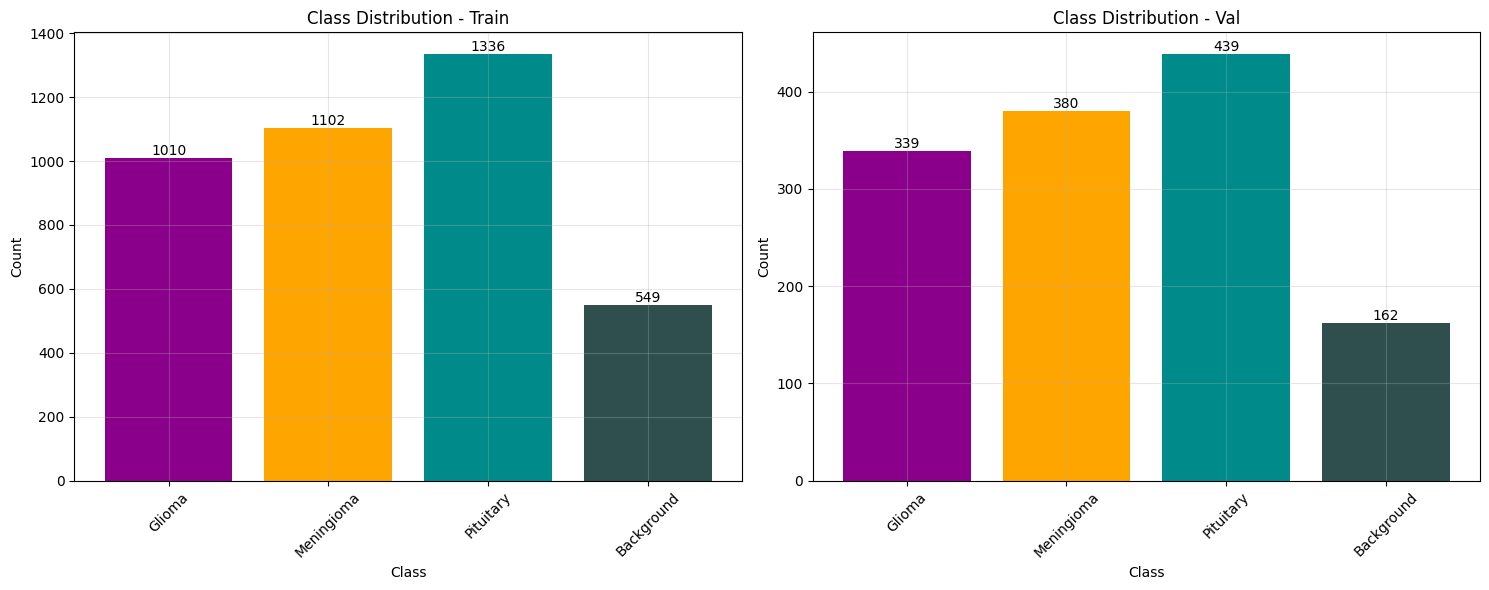

In [ ]:
# Plot the class distribution for the training and validation datasets
plot_class_distribution()


Visualizing training samples...


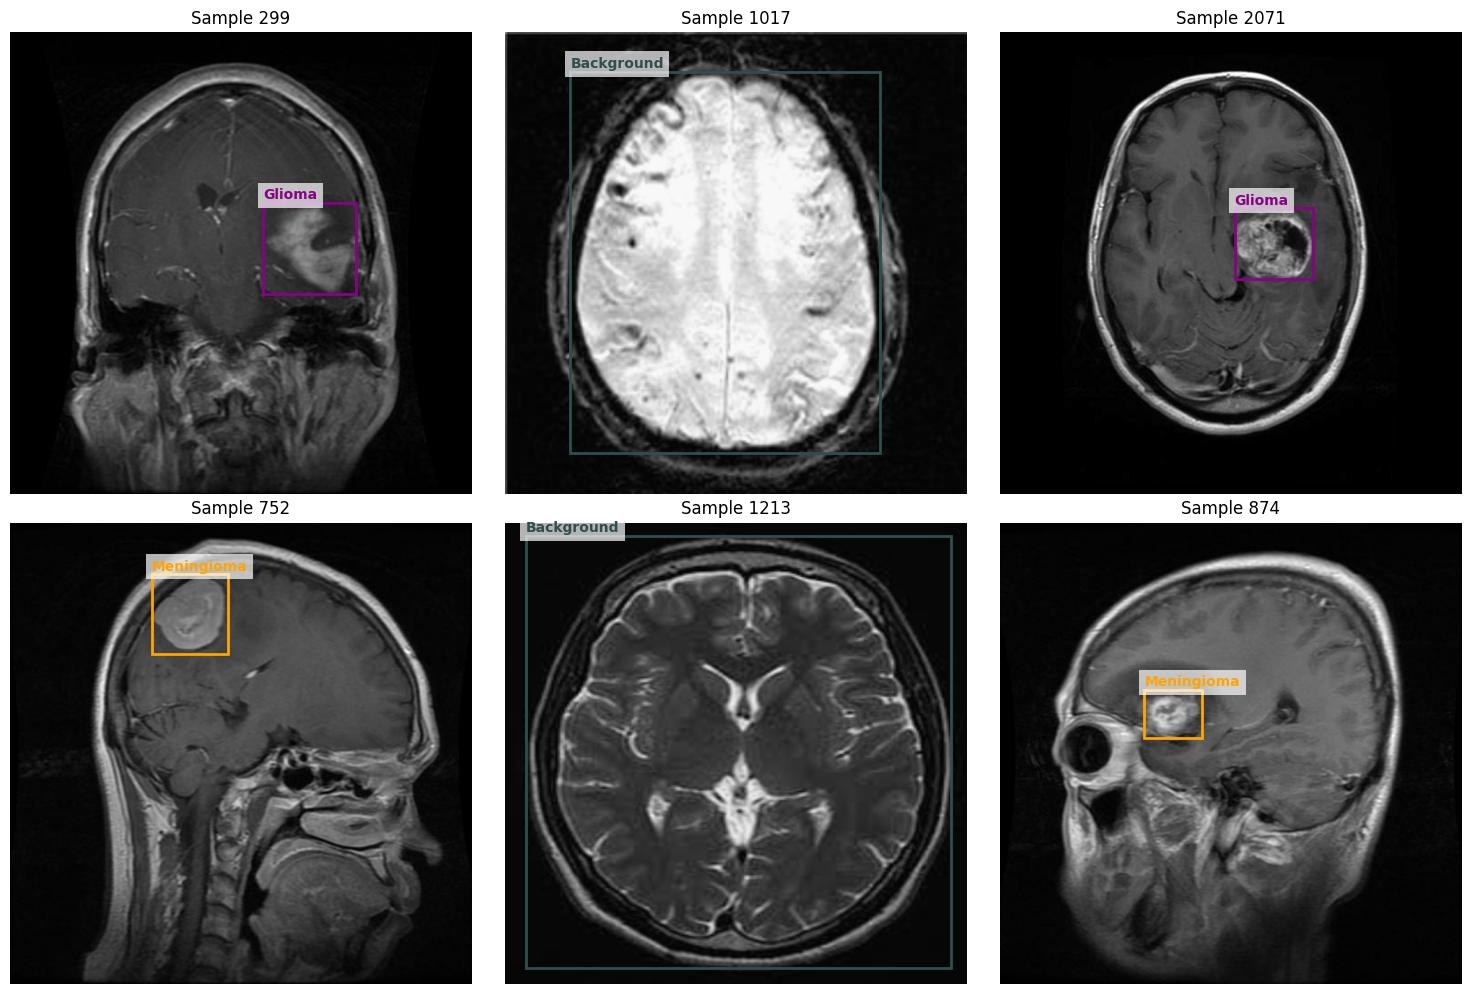

In [ ]:
# Initialize the training dataset with augmentations and transformations
train_dataset = BrainTumorDataset(
    split='train',
    transform=transforms.Compose([
        transforms.Resize((config.target_image_size, config.target_image_size)),
        transforms.ToTensor()
    ]),
    augment=True
)

# Print a message indicating the start of visualization
print("\nVisualizing training samples...")

# Visualize random samples from the training dataset
visualize_dataset_samples(train_dataset)

In [ ]:
# Define the path to the dataset configuration YAML file
data_yaml = config.data_root / "data.yaml"

# Write the dataset configuration to the YAML file
with open(data_yaml, 'w') as f:
    yaml.dump({
        'path': str(config.data_root),  # Root directory for the dataset
        'train': 'train',               # Subdirectory for training data
        'val': 'val',                   # Subdirectory for validation data
        'nc': len(config.class_labels), # Number of classes
        'names': list(config.class_labels.values())  # List of class names
    }, f)

# Determine the device to use for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the YOLO model and move it to the specified device
model = initialize_model(device)

In [ ]:
# Train the YOLO model using the dataset configuration from the YAML file
# The function 'train_model' initializes the training process with the specified parameters
# and returns the training results and the trained model.

results, trained_model = train_model(model, data_yaml)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=datasets/data.yaml, epochs=5, time=None, patience=15, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

train: Scanning /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/datasets/train/labels.cache... 3552 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3552/3552 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/datasets/val/labels.cache... 1185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1185/1185 [00:00<?, ?it/s]


Plotting labels to /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.68G      1.394      1.875      1.573         21        640: 100%|██████████| 296/296 [02:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]

                   all       1185       1320      0.655      0.531      0.563      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       5.7G      1.363      1.495      1.563         25        640: 100%|██████████| 296/296 [02:18<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]

                   all       1185       1320      0.745      0.636      0.726      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.69G      1.292      1.324       1.51         17        640: 100%|██████████| 296/296 [02:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]

                   all       1185       1320      0.746       0.74      0.805      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.68G      1.214      1.092      1.436         30        640: 100%|██████████| 296/296 [02:24<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

                   all       1185       1320      0.843      0.793      0.864      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.69G      1.133     0.9549      1.383         32        640: 100%|██████████| 296/296 [02:26<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

                   all       1185       1320      0.908      0.858      0.927      0.614



5 epochs completed in 0.220 hours.
Optimizer stripped from /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train/weights/best.pt, 52.0MB

Validating /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.9.20 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


                   all       1185       1320      0.908      0.857      0.927      0.614
                Glioma        295        339      0.882      0.619      0.822      0.524
            Meningioma        374        380      0.957      0.961      0.979      0.702
             Pituitary        162        162      0.967      0.975      0.992      0.703
            Background        416        439      0.825      0.875      0.915      0.527
Speed: 0.2ms preprocess, 12.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train


In [ ]:
# Evaluate the trained model on the validation dataset
metrics = trained_model.val()

# Print the final validation metrics
print("\nFinal Validation Metrics:")
print(f"mAP50-95: {metrics.box.map:.4f}")  # Mean Average Precision at IoU thresholds from 50% to 95%
print(f"Precision: {metrics.box.mp:.4f}")  # Precision of the model
print(f"Recall: {metrics.box.mr:.4f}")     # Recall of the model
# Calculate and print the F1 Score, which is the harmonic mean of Precision and Recall
print(f"F1 Score: {2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr + 1e-6):.4f}")

Ultralytics 8.3.75 🚀 Python-3.9.20 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/datasets/val/labels.cache... 1185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1185/1185 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


                   all       1185       1320      0.908      0.857      0.926      0.614
                Glioma        295        339      0.878      0.616       0.82      0.525
            Meningioma        374        380      0.957      0.961      0.979      0.702
             Pituitary        162        162      0.971      0.975      0.991      0.702
            Background        416        439      0.825      0.875      0.915      0.525
Speed: 0.3ms preprocess, 22.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/victor_moraes/Documentos/Unb/NOIA/Trabalho-final-NOIA/runs/detect/train2

Final Validation Metrics:
mAP50-95: 0.6136
Precision: 0.9077
Recall: 0.8566
F1 Score: 0.8814


### Análise de métricas obtidas

- *mAP50-90*: Métrica da própria YOLO e da uma visão abrangente do desempenho do modelo em diferentes níveis de dificuldade de detecção varinado de 50% a 95%. Assim, quanto maior o valor, melhor o modelo se adaptou a maiores dificuldades de detecção, assim o valor de 61,36% para a métrica é um resultado razoavelmente bom ao se considerar que o modelo tem que identificar se um paciente tem ou não um tumor e, se tiver, classificar entre 3 diferentes tipos de tumor.

- *Precisão*: Métrica usada para mostrar a porcentagem de previsões corretas da classe positivo, ou seja, quanto maior o valor, menos valores falsos positivos teremos. Assim, o valor de 90,77% corresponde a um valor muito bom para o modelo, pois destaca que a quantidade de falsos positivos é bem menor que a quantidade de verdadeiros positivos, que destaca que acertou muito as classificações em que colocou as imagens.

- *Recall (ou Sensibilidade)*: Métrica utilizada para mostrar a porcentagem de de positivos capturada pelo modelo, ou seja, quanto maior o valor, menos valores falsos negativos teremos. Assim, o valor de 85,66% corresponde mais uma vez a um valor muito bom para o modelo, pois destaca que temos uma grande quantidade de verdadeiros positivos em relação aos falsos negativos, mas ainda assim, é um valor maior de falsos negativos do que falsos positivos, como pudemos ver na anális da métrica de precisão acima.

- *Score F1*: Métrica de média harmônica entre as métricas de Precisão e Recall. Assim, o valor de 88,14% é condizente com as duas métricas analisadas anteriormente e mostra que as duas se saíram bem separadamente e, também, ao se fazer a média das duas, destacando o quão bom foi o modelo treinado.

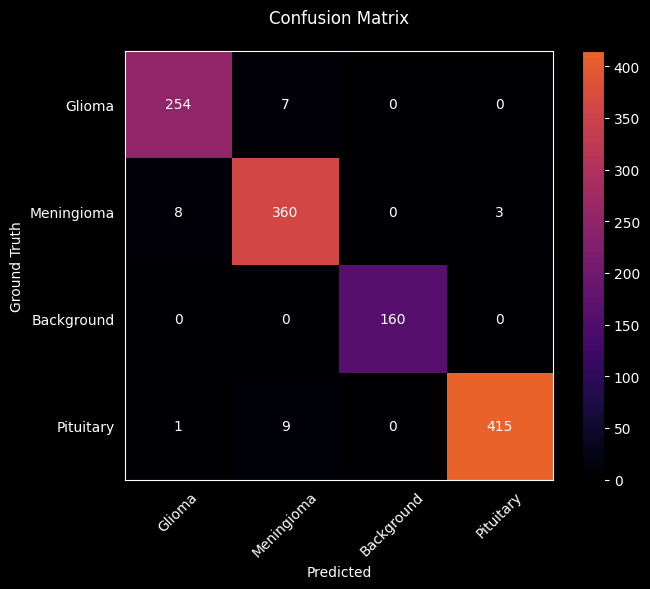

In [41]:
plot_confusion_matrix(metrics.confusion_matrix)

### Análise da Matriz de Confusão

Podemos ver que, na matriz de confusão acima, gerada a partir das imagens que usamos como teste de validação, temos a maior concentração de valores obtidos nos verdadeiros positivos, em que a predição condiz com o valor verdadeiro da classificação da imagem do raio-x para identificar o se tem, ou não, tumor cerebral e qual é o tumor. Dessa forma, essa matriz de confusão nos mostra que o modelo treinado obteve um resultado muito satisfatório, tendo pouquíssimos valores não presentes na diagonal principal da matriz, caracterizada por esses valores verdadeiros positivos. Percebe-se também que, a maior confusão encontrada no modelo foi com o o tumor predito como Meningioma, mas na verdade é o tumor pituitário.


0: 640x640 1 Background, 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Background, 18.6ms
Speed: 0.0ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Background, 18.6ms
Speed: 0.0ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


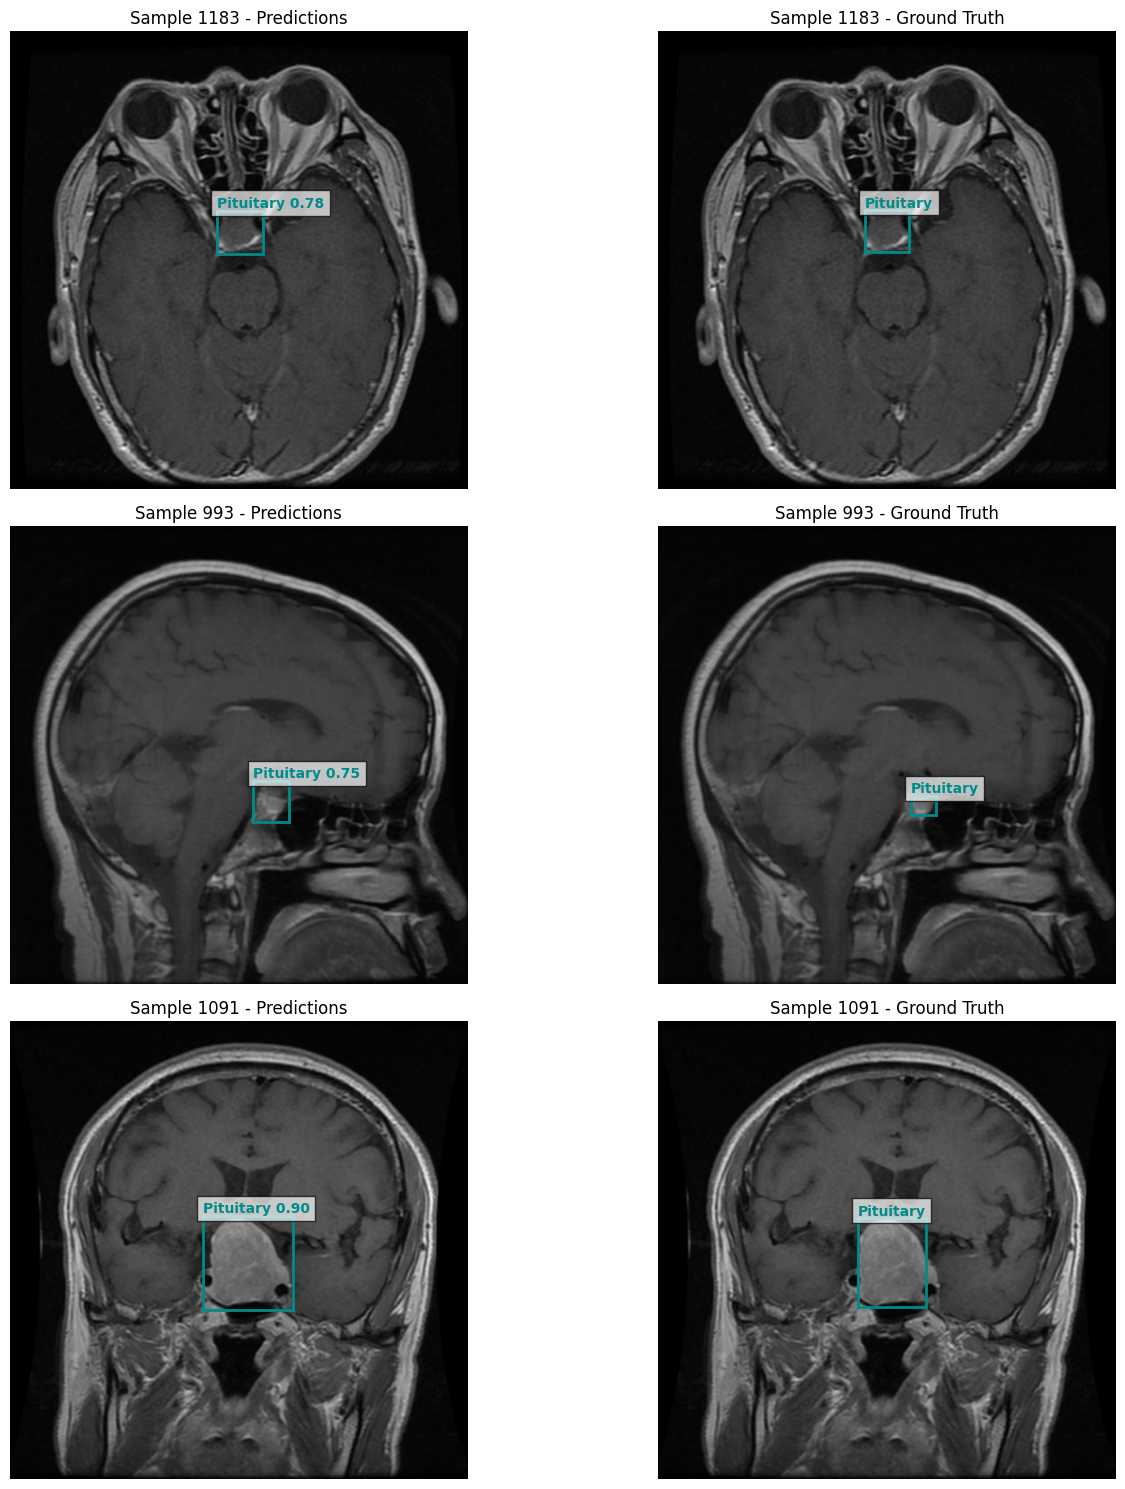

In [ ]:
# Initialize the validation dataset with augmentations and transformations
validation_dataset = BrainTumorDataset(
    split='val',
    transform=transforms.Compose([
        transforms.Resize((config.target_image_size, config.target_image_size)),
        transforms.ToTensor()
    ]),
    augment=True
)

# Load the best model from the training process and move it to the specified device
best_model = YOLO('runs/detect/train/weights/best.pt').to(device)

# Compare predictions of the best model with the ground truth on the validation dataset
# Display side-by-side comparisons for a specified number of random samples
compare_predictions(best_model, validation_dataset, num_samples=3)

### Análise das últimas 3 imagens para predição do tumor
Essas 3 imagens de raio-x mostradas acima mostram, ao lado esquerdo, qual é a predição do tipo do tumor encontado do modelo e qual a porcentagem de certeza que ele dá a essa classificação dada e, ao lado direito, a classificação correta do tumor mostrado nas imagens. Dessa maneira, com essas 3 imagens mostradas, percebe-se que o modelo acertou nas 3 classificações de tumor do tipo pituitário, com todas as porcentagens de certeza superior a 75%, que mais uma vez mostra um bom comportamento do modelo treinado.

### Considerações finais

O modelo treinado definitivamente obteve bons resultado e, isso, pode-se ver pelas métricas geradas, pela matriz de confusão e por algumas imagens com a predição e a classificação real. Porém, ao se considerar o intuito que o modelo foi criado, todo espaço para melhoras é válido, já que ele foi treinado para classificar possíveis tumores cerebrais e qual é o seu tipo, o que pode ajudar muito com o avanço da medicina de tratar o mais rápido pacientes com esses tipos de tumores. Sendo assim, mesmo tendo bons resultados, sempre temos espaço para melhoras, ainda mais considerando que pode-se contribuir com velocidade de diagnóstico dos tumores e, consequentemente, maior velocidade com o tratamento deles.

### Interpretando Aparências de Tumores

Compreender as características visuais dos diferentes tipos de tumores cerebrais é essencial para interpretar as previsões de modelos. Embora este conjunto de dados forneça anotações com caixas delimitadoras, aqui está um guia geral para ajudar a identificar os tumores com base em suas aparências típicas em exames médicos (especificamente, presumindo que essas imagens sejam provavelmente de ressonância magnética - MRI - ou tomografia computadorizada - CT -, embora isso precise ser verificado se a fonte dos dados for conhecida). Lembre-se de que a aparência pode variar significativamente, e este é um resumo simplificado.

#### **Glioma**
Os gliomas são tumores que se originam das células gliais, que dão suporte aos neurônios no cérebro.

- **Aparência:** 
  - Costumam ter uma forma irregular e bordas mal definidas, o que os faz parecer infiltrativos.
  - A textura interna pode ser heterogênea, com áreas de necrose (tecido morto), hemorragia (sangramento) ou cistos (cavidades preenchidas por líquido).
  - A intensidade do tumor nas imagens de MRI (ou CT) varia dependendo do tipo específico de glioma e da presença dessas características internas.
  - Gliomas de grau mais alto (como o glioblastoma) são mais propensos a ter essas características irregulares.

#### **Meningioma**
Os meningiomas surgem das meninges, as membranas que envolvem o cérebro e a medula espinhal.

- **Aparência:** 
  - Geralmente são massas bem definidas, de formato arredondado ou oval, aderidas à dura-máter (camada mais externa das meninges).
  - Frequentemente, apresentam uma base larga contra o crânio.
  - Em imagens com contraste, os meningiomas geralmente mostram um realce forte e homogêneo (tornam-se mais brilhantes após a injeção do agente de contraste).
  - Um achado característico é a "cauda dural" (espessamento da dura-máter que se estende a partir do tumor).

#### **Adenoma de Hipófise**
Os adenomas hipofisários são tumores que se desenvolvem na glândula pituitária, uma pequena glândula localizada na base do cérebro.

- **Aparência:** 
  - Esses tumores estão localizados na sela túrcica (uma estrutura óssea que abriga a hipófise).
  - Microadenomas (tumores pequenos) podem ser sutis e requerer sequências específicas de MRI para detecção.
  - Macroadenomas (tumores maiores) podem comprimir o quiasma óptico (onde os nervos ópticos se cruzam), levando a distúrbios visuais.
  - Normalmente, têm formato arredondado ou oval e podem realçar com contraste, mas o padrão pode variar.


### Interpretando Aparências de Tumores

Compreender as características visuais dos diferentes tipos de tumores cerebrais é essencial para interpretar as previsões de modelos. Embora este conjunto de dados forneça anotações com caixas delimitadoras, aqui está um guia geral para ajudar a identificar os tumores com base em suas aparências típicas em exames médicos (especificamente, presumindo que essas imagens sejam provavelmente de ressonância magnética - MRI - ou tomografia computadorizada - CT -, embora isso precise ser verificado se a fonte dos dados for conhecida). Lembre-se de que a aparência pode variar significativamente, e este é um resumo simplificado.

#### **Glioma**
Os gliomas são tumores que se originam das células gliais, que dão suporte aos neurônios no cérebro.

- **Aparência:** 
  - Costumam ter uma forma irregular e bordas mal definidas, o que os faz parecer infiltrativos.
  - A textura interna pode ser heterogênea, com áreas de necrose (tecido morto), hemorragia (sangramento) ou cistos (cavidades preenchidas por líquido).
  - A intensidade do tumor nas imagens de MRI (ou CT) varia dependendo do tipo específico de glioma e da presença dessas características internas.
  - Gliomas de grau mais alto (como o glioblastoma) são mais propensos a ter essas características irregulares.

#### **Meningioma**
Os meningiomas surgem das meninges, as membranas que envolvem o cérebro e a medula espinhal.

- **Aparência:** 
  - Geralmente são massas bem definidas, de formato arredondado ou oval, aderidas à dura-máter (camada mais externa das meninges).
  - Frequentemente, apresentam uma base larga contra o crânio.
  - Em imagens com contraste, os meningiomas geralmente mostram um realce forte e homogêneo (tornam-se mais brilhantes após a injeção do agente de contraste).
  - Um achado característico é a "cauda dural" (espessamento da dura-máter que se estende a partir do tumor).

#### **Adenoma de Hipófise**
Os adenomas hipofisários são tumores que se desenvolvem na glândula pituitária, uma pequena glândula localizada na base do cérebro.

- **Aparência:** 
  - Esses tumores estão localizados na sela túrcica (uma estrutura óssea que abriga a hipófise).
  - Microadenomas (tumores pequenos) podem ser sutis e requerer sequências específicas de MRI para detecção.
  - Macroadenomas (tumores maiores) podem comprimir o quiasma óptico (onde os nervos ópticos se cruzam), levando a distúrbios visuais.
  - Normalmente, têm formato arredondado ou oval e podem realçar com contraste, mas o padrão pode variar.
